In [16]:
import os
import sys
# Set the current working directory to the directory of this script
if '__file__' in globals():
    # Running as a .py script, changes working directory to the script's directory
    os.chdir(os.path.dirname(os.path.abspath(__file__)))
else:
    # Running inside a notebook
    os.chdir(os.getcwd())  # stays in notebook folder, no need for above if statement
#Created as want to continuously export this notebook to a python script
# and run it as a script, so need to set the working directory to the script

In [17]:
import pandas as pd
import glob
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.metrics import root_mean_squared_error
from xgboost import plot_importance

IMPORTING/ CLEANING DATA

In [18]:
#import 2015 to 2025 MW demand data, ignore title row from each and concatenate all csv files together by row, adding new title row
path = "IESO_MW_Data"
all_files = glob.glob(path + "/*.csv")
dfs = []
for files in all_files:
    df_2 = pd.read_csv(files, skiprows=1, header=None)
    df_2.columns = ["Datetime", "Hour", "Market Demand", "Ontario Demand"]
    dfs.append(df_2)
df = pd.concat(dfs, ignore_index=True, axis=0)

In [19]:

#Set hour to numeric, replace hour 24 with hour 0 for easier datetime conversion
df['Hour']=pd.to_numeric(df['Hour'], errors='coerce')
df['Hour'] = df['Hour'].replace(24,0)


#Convert Date column to datetime format, combine with hour column, drop hour column
df['Datetime'] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df["Datetime"] = df["Datetime"] + pd.to_timedelta(df['Hour'], unit='h')
df = df.set_index('Datetime')
df.drop(columns=['Hour'], inplace=True)
df.drop(columns=['Market Demand'], inplace=True)
df

,Ontario Demand
Datetime,
2015-01-01 01:00:00,14960
2015-01-01 02:00:00,14476
2015-01-01 03:00:00,13979
2015-01-01 04:00:00,13670
2015-01-01 05:00:00,13567
...,...
2025-08-04 20:00:00,19639
2025-08-04 21:00:00,19156
2025-08-04 22:00:00,18074


In [20]:
#Separate train and test sets (trial: 70/30 split)

#Determine number of unique hours in Datetime index, calculate 70% of that number
train_hours = int(df.index.nunique() * 0.7)

#Split train and test sets using index values for slicing
train = df[df.index <= df.index[train_hours]].copy()
test = df[df.index > df.index[train_hours]].copy()
train


,Ontario Demand
Datetime,
2015-01-01 01:00:00,14960
2015-01-01 02:00:00,14476
2015-01-01 03:00:00,13979
2015-01-01 04:00:00,13670
2015-01-01 05:00:00,13567
...,...
2022-06-01 03:00:00,13803
2022-06-01 04:00:00,13941
2022-06-01 05:00:00,14203


VISUALIZATION

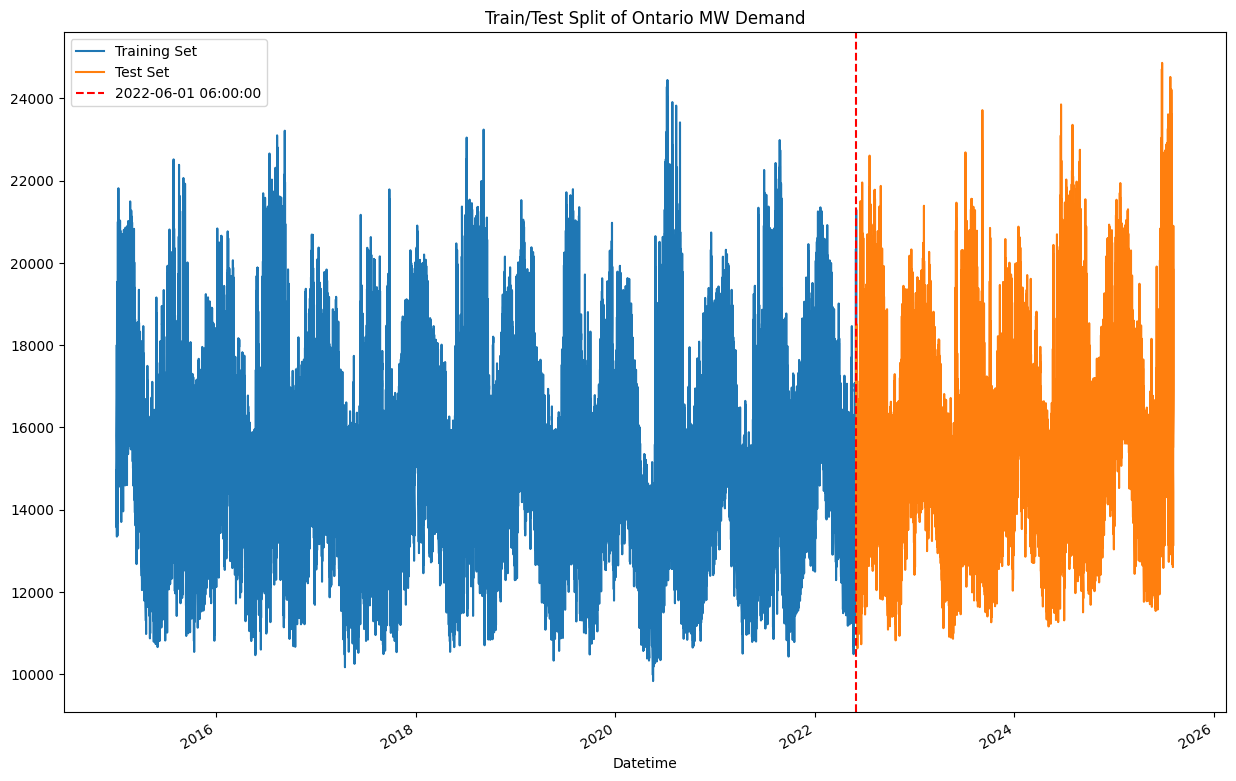

In [21]:
#Plotting train and test sets visualization 
fig, ax = plt.subplots(figsize = (15,10))
train.plot(ax=ax, label='Training Set', title='Train/Test Split of Ontario MW Demand')
test.plot(ax=ax, label='Test Set')
ax.axvline(df.index[train_hours], label = df.index[train_hours],color='red', ls='--')
ax.legend(['Training Set', 'Test Set', df.index[train_hours]])
plt.show()

FEATURE CREATION - HOLIDAYS

In [22]:
#Import Canadian holidays dataset (pulled from https://github.com/uWaterloo/Datasets/blob/master/Holidays/holidays.csv)
holidays = pd.read_csv("Canadian_Holidays_Data/holidays.csv")
holidays['date'] = pd.to_datetime(holidays["date"], format="%Y-%m-%d")
holidays = holidays.set_index('date')
holidays

,holiday
date,
2012-01-02,New Year's Day
2012-02-20,Family Day
2012-04-06,Good Friday
2012-05-21,Victoria Day
2012-07-02,Canada Day
...,...
2026-02-16,Family Day
2026-04-03,Good Friday
2026-05-18,Victoria Day


FEATURE CREATION - TEMPERATURE

In [23]:
#Import Ontario Temperature data (pulled from https://climate-change.canada.ca/climate-data/#/daily-climate-data)
#Scraped daily temperature readings from weather stations in and near hubs such as Toronto, Ottawa, Sudbury, Kenora, Sault Ste. Marie, etc.

#Set path to these temperature data files, combine files into one dataframe
path = "Ontario_Weather_Data"
all_weather_files = glob.glob(path + "/*.csv")
weather_dfs = []
for files in all_weather_files:
    df_3 = pd.read_csv(files, skiprows=1,usecols=[2,5,10], header=None)
    #Columns used: Station Name, Date, Mean Temperature
    df_3.columns = ["Station Name", "Date", "Mean Temperature"]
    weather_dfs.append(df_3)
weather_df = pd.concat(weather_dfs, ignore_index=True, axis=0)
weather_df

,Station Name,Date,Mean Temperature
0,HARTINGTON IHD,1995-05-19 0:00,12.0
1,HARTINGTON IHD,1995-05-20 0:00,11.5
2,HARTINGTON IHD,1995-05-21 0:00,14.3
3,HARTINGTON IHD,1995-05-22 0:00,12.0
4,HARTINGTON IHD,1995-05-23 0:00,14.0
...,...,...,...
51383,TORONTO BUTTONVILLE A,2015-05-16 0:00,19.0
51384,TORONTO BUTTONVILLE A,2015-05-17 0:00,18.7
51385,TORONTO BUTTONVILLE A,2015-05-18 0:00,21.8
51386,TORONTO BUTTONVILLE A,2015-05-19 0:00,12.5


In [24]:
#Within weather dataframe convert Date column to datetime format, set as index 
weather_df['Date'] = pd.to_datetime(weather_df["Date"], errors='coerce')
#weather_df = weather_df.set_index('Date')
weather_df['Average Temperature'] = pd.to_numeric(weather_df['Mean Temperature'], errors='coerce')
average_temp = weather_df.groupby(weather_df["Date"].dt.date)['Mean Temperature'].mean()

average_temp = average_temp.reset_index()
average_temp['Date'] = pd.to_datetime(average_temp['Date'], errors='coerce')
average_temp.set_index('Date', inplace=True)

#average_temp.to_csv("Ontario_Average_Temperature.csv")

In [25]:
#Train feature creation by breaking down hourly MW datetime index into time components
train['Year'] = train.index.year
train['Month'] = train.index.month
train['DayOfMonth'] = train.index.day
train['DayOfYear'] = train.index.dayofyear
train['Hour'] = train.index.hour
train['DayOfWeek'] = train.index.dayofweek
train['WeekOfYear'] = train.index.isocalendar().week
train['Quarter'] = train.index.quarter

#Create holiday feature by setting holiday dates to true and non holidays to false 
train['Holiday'] = train.index.date
train['Holiday'] = train['Holiday'].isin(holidays.index.date).astype(bool)

#Create average temperature feature by mapping the average temperature to the date index in train set
train['Temperature'] = train.index.date
train['Temperature'] = train.index.normalize().map(average_temp['Mean Temperature']).astype(float)

#Test feature creation by breaking down hourly MW datetime index into time components
test['Year'] = test.index.year
test['Month'] = test.index.month
test['DayOfMonth'] = test.index.day
test['DayOfYear'] = test.index.dayofyear
test['Hour'] = test.index.hour
test['DayOfWeek'] = test.index.dayofweek
test['WeekOfYear'] = test.index.isocalendar().week
test['Quarter'] = test.index.quarter

#Create holiday feature by setting holiday dates to true and non holidays to false 
test['Holiday'] = test.index.date
test['Holiday'] = test['Holiday'].isin(holidays.index.date).astype(bool)

#Create average temperature feature by mapping the average temperature to the date index in test set
test['Temperature'] = test.index.date
test['Temperature'] = test.index.normalize().map(average_temp['Mean Temperature']).astype(float)

#train.to_csv("Ontario_MW_Train.csv")

TRAINING

In [26]:
#Training XGBoost model

#Assigning independent and dependent variables to dataframes
train_features = train[['Year', 'Month', 'DayOfMonth', 'DayOfYear', 'Hour', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Holiday', 'Temperature']]
train_target = train['Ontario Demand']

test_features = test[['Year', 'Month', 'DayOfMonth', 'DayOfYear', 'Hour', 'DayOfWeek', 'WeekOfYear', 'Quarter', 'Holiday', 'Temperature']]
test_target = test['Ontario Demand']

In [27]:
#establishing model parameters and training model
model = xgb.XGBRegressor(n_estimators=5000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(train_features, train_target, eval_set=[(train_features, train_target), (test_features, test_target)], verbose=100)

[0]	validation_0-rmse:2320.96868	validation_1-rmse:2384.74609
[100]	validation_0-rmse:1308.04735	validation_1-rmse:1497.41863
[200]	validation_0-rmse:977.39174	validation_1-rmse:1265.54143
[300]	validation_0-rmse:852.74505	validation_1-rmse:1204.92572
[400]	validation_0-rmse:790.82685	validation_1-rmse:1156.71706
[500]	validation_0-rmse:746.82862	validation_1-rmse:1123.17779
[600]	validation_0-rmse:715.86326	validation_1-rmse:1102.87642
[700]	validation_0-rmse:691.69702	validation_1-rmse:1048.99024
[800]	validation_0-rmse:672.34848	validation_1-rmse:1037.20311
[900]	validation_0-rmse:655.06713	validation_1-rmse:1034.16813
[1000]	validation_0-rmse:637.05896	validation_1-rmse:1034.68078
[1002]	validation_0-rmse:636.77529	validation_1-rmse:1034.81740


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [28]:
#Checking baseline RMSE
prediction_mean = np.mean(train_target)
baseline_rmse = root_mean_squared_error(train_target, np.full_like(train_target, prediction_mean))
print("Baseline RMSE (mean prediction): " + str(baseline_rmse))

Baseline RMSE (mean prediction): 2338.316064584209


TESTING MODEL

In [29]:
#predicting MW demand for test set
test['Predicted Demand'] = model.predict(test_features)
#Calculating RMSE for test set predictions
test_RMSE = root_mean_squared_error(test_target, test['Predicted Demand'])
print(test_RMSE)
test

1032.536865234375


,Ontario Demand,Year,Month,DayOfMonth,DayOfYear,Hour,DayOfWeek,WeekOfYear,Quarter,Holiday,Temperature,Predicted Demand
Datetime,,,,,,,,,,,,
2022-06-01 07:00:00,16729,2022,6,1,152,7,2,22,2,False,13.025000,15247.693359
2022-06-01 08:00:00,18058,2022,6,1,152,8,2,22,2,False,13.025000,15638.123047
2022-06-01 09:00:00,18236,2022,6,1,152,9,2,22,2,False,13.025000,15900.406250
2022-06-01 10:00:00,17721,2022,6,1,152,10,2,22,2,False,13.025000,15953.267578
2022-06-01 11:00:00,17490,2022,6,1,152,11,2,22,2,False,13.025000,16006.292969
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-04 20:00:00,19639,2025,8,4,216,20,0,32,3,True,18.014286,17719.109375
2025-08-04 21:00:00,19156,2025,8,4,216,21,0,32,3,True,18.014286,17238.527344
2025-08-04 22:00:00,18074,2025,8,4,216,22,0,32,3,True,18.014286,16089.631836


FEATURE IMPORTANCE

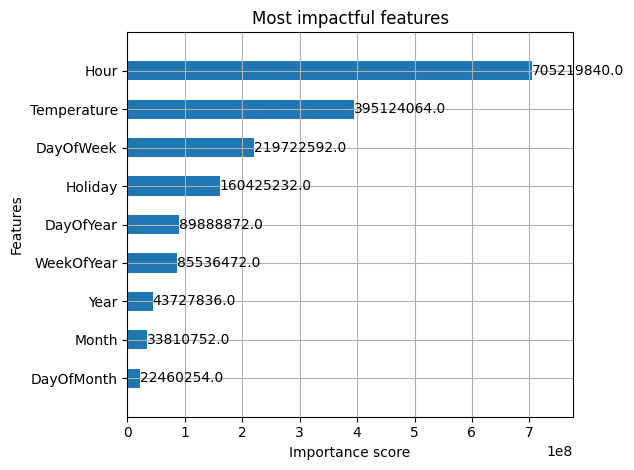

In [30]:
#Examining feature importance
plot_importance(model, importance_type='gain', max_num_features=10, height=0.5)
plt.title("Most impactful features")
plt.tight_layout()
plt.show()